### How To: Evaluate model performance
Author: Jacob Schreiber

After training a model, the next step is almost always to evaluate model performance on a held-out test set. Similarly, when one has downloaded a model from somewhere else, the first step is usually to confirm that the model is performant in ways that are most interesting to the user. In this notebook, we will explore how to evaluate the performance of a model using the standard performance measures for Chrom/BPNet. I will emphasize that there is usually no single performance measure that is sufficient to evaluate performance or to compare two models and that measures which are basically slightly different equations on the same data (e.g., accuracy vs auROC or MSE vs MAE) are not that helpful. Rather, one should rely on a collection of performance measures that chop up the data in different ways, such as by focusing on differential predictions at important regions or splitting data into highly active and inactive regions.

In an earlier tutorial, we used the pipeline command to train a BPNet model to predict JUN binding. Here, we will walk through how to load up this model and use some of the built-in evaluation measures to evaluate it's performance. Because this is a tutorial for bpnet-lite, we will focus on the measures that are implemented in this repository, but one is always free to additionally evaluate their models in other ways.

#### Loading up the evaluation data

For the purpose of demonstration, we will focus on evaluating performance of the model in called peaks. So, we will need to load up the sequences and signals at those regions.

In [4]:
from tangermeme.io import extract_loci

peaks = "ENCFF331IUK.bed.gz"
seq = "/home/jmschrei/common/hg38.fa"
sig = ["quick-jun.+.bw", "quick-jun.-.bw"]
test_chroms = ['chr8', 'chr20'] # Remember to not include training set chroms!

X, y = extract_loci(peaks, seq, sig, chroms=test_chroms, verbose=True)
X.shape, y.shape

Loading Loci: 100%|██████████████████████████████████████████████████████████████| 1600/1600 [00:00<00:00, 11528.49it/s]


(torch.Size([1600, 4, 2114]), torch.Size([1600, 2, 1000]))

Now, we will use our model to make predictions for those regions.

In [6]:
import torch
from tangermeme.predict import predict

model = torch.load("quick-atac/model.torch", weights_only=False)

y_logits, y_log_counts = predict(model, X, verbose=True)
y_logits.shape, y_log_counts.shape

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.87it/s]


(torch.Size([1600, 1, 1000]), torch.Size([1600, 1]))

We can start off by visualizing the predictions and the true data. Visualizations are always an important complement to the raw performance measures, because there are sometimes systematic issues that one cannot see from numbers alone but become immediately apparent in even a simple scatterplot.

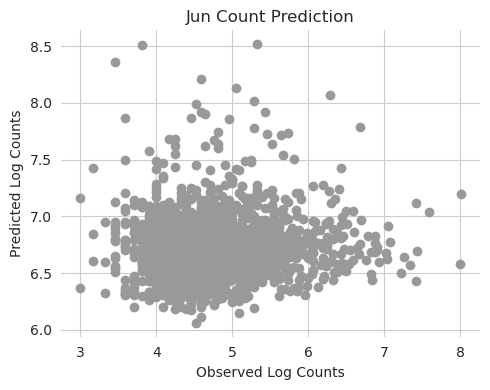

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

y_log = torch.log2(y[:, 0].sum(dim=-1) + 1)

plt.figure(figsize=(5, 4))
plt.scatter(y_log, y_log_counts[:, 0], c='0.6')
plt.title("Jun Count Prediction")
plt.xlabel("Observed Log Counts")
plt.ylabel("Predicted Log Counts")

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

We can also take a look at the profile predictions and compare them to the raw read counts for a region. 

In [40]:
idx = 0

y_profile = torch.softmax(y_logits[idx], dim=-1)

plt.figure(figsize=(12, 3))
plt.subplot(211)
plt.bar(range(1000), y[idx, 0], edgecolor='0.5')
plt.bar(range(1000), y[idx, 1], edgecolor='0.8')
plt.ylabel("Observed Counts")
seaborn.despine(bottom=True, left=True)

plt.subplot(212)
plt.bar(range(1000), y_profile[0], edgecolor='0.5', facecolor='0.5')
plt.bar(range(1000), y_profile[0], edgecolor='0.8', edgecolor='0.8')
plt.xlabel("Genomic Position")
plt.ylabel("Predicted Profile")
seaborn.despine(bottom=True, left=True)

plt.tight_layout()
plt.show()

SyntaxError: keyword argument repeated: edgecolor (2092550147.py, line 14)

### Calculating all the performance measures

Now that we have the predictions across all peaks and the true readouts for those regions, and have verified that nothing seems to be systematically wrong with the predictions, we can calculate the set of performance measures usually used for the BPNet models. This includes several measures of performance on the profile predictions, which are returned on a per-example basis, and several measures of performance on the log count predictions measured across the entire dataset.

To make it easy to calculate these measures, bpnet-lite has a built-in `calculate_performance_measures` method that takes in a set of predicted logit, log counts, and the true signal, and returns each of the measures as a dictionary.

In [41]:
from bpnetlite.performance import calculate_performance_measures

calculate_performance_measures(y_logits.repeat(1, 2, 1), y, y_log_counts)

{'profile_mnll': tensor([[201.3169, 202.1179],
         [172.7471, 127.4021],
         [139.8165,  90.2573],
         ...,
         [630.8956, 631.9704],
         [614.3235, 619.7435],
         [990.7087, 964.4036]]),
 'profile_jsd': tensor([[0.6141, 0.6260],
         [0.6307, 0.6511],
         [0.6481, 0.6378],
         ...,
         [0.4793, 0.4978],
         [0.4937, 0.5368],
         [0.5259, 0.4994]]),
 'profile_pearson': tensor([[ 0.0156,  0.0007],
         [ 0.0049, -0.0062],
         [-0.0104,  0.0705],
         ...,
         [ 0.1148,  0.0847],
         [ 0.1077,  0.0193],
         [-0.0510,  0.0170]]),
 'profile_spearman': tensor([[-0.0749, -0.0849],
         [-0.0641, -0.0522],
         [-0.0549, -0.0478],
         ...,
         [ 0.0388,  0.1293],
         [ 0.0154, -0.0318],
         [-0.0766, -0.0634]]),
 'count_pearson': tensor([0.0879]),
 'count_spearman': tensor([0.0990]),
 'count_mse': tensor([7.7301])}

There are several arguments that can be passed in to change the exact way that these measures are calculated. In the original BPNet paper, the *true* profiles are smoothed using a Gaussian filter with a sigma of 7 and a kernel width of 81. Those parameters can be passed in, and we can turn them on with the `smooth_true` argument.

In [44]:
calculate_performance_measures(y_logits.repeat(1, 2, 1), y, y_log_counts, smooth_true=True)

{'profile_mnll': tensor([[201.3169, 202.1179],
         [172.7471, 127.4021],
         [139.8165,  90.2573],
         ...,
         [630.8956, 631.9704],
         [614.3235, 619.7435],
         [990.7087, 964.4036]]),
 'profile_jsd': tensor([[0.3168, 0.3349],
         [0.3746, 0.4293],
         [0.3876, 0.4523],
         ...,
         [0.3608, 0.3652],
         [0.3629, 0.4201],
         [0.4074, 0.3665]]),
 'profile_pearson': tensor([[ 0.0607,  0.0516],
         [-0.0109, -0.0764],
         [-0.0373, -0.0145],
         ...,
         [ 0.1246,  0.1402],
         [ 0.0583, -0.0069],
         [-0.0417,  0.0034]]),
 'profile_spearman': tensor([[ 0.0559,  0.1152],
         [ 0.0059, -0.1455],
         [ 0.0227, -0.0604],
         ...,
         [ 0.1525,  0.0833],
         [ 0.1089,  0.0192],
         [-0.0683,  0.0675]]),
 'count_pearson': tensor([0.0879]),
 'count_spearman': tensor([0.0990]),
 'count_mse': tensor([7.7301])}

My personal opinion is that one should never smooth the true profile, but it is implemented in case you want to more closely match other repositories.

By default, the count performances are a single value across the entire dataset even when there are multiple strands, whereas the profile measures are 

The count performance measures as a single number across the entire dataset, whereas the profile measures are calculated per example.

By default, the profile performance measures are calculated on a per-strand basis. This does not matter for chromatin accessibility models but does matter for those trained on ChIP-seq, ProCAP, or any other experiment that yields stranded signal. If you want to calculate a single value across both strands you can concatenate the two strands together before calculating the performance measures like this:

In [39]:
calculate_performance_measures(
    y_logits.repeat(1, 2, 1).reshape(y_logits.shape[0], -1).unsqueeze(1), 
    y.reshape(y.shape[0], -1).unsqueeze(1),
    y_log_counts
)

{'profile_mnll': tensor([[ 405.8675],
         [ 303.4930],
         [ 233.1341],
         ...,
         [1266.0159],
         [1237.5779],
         [1958.4983]]),
 'profile_jsd': tensor([[0.6200],
         [0.6405],
         [0.6438],
         ...,
         [0.4885],
         [0.5148],
         [0.5128]]),
 'profile_pearson': tensor([[ 8.2375e-03],
         [-4.3767e-05],
         [ 2.5481e-02],
         ...,
         [ 9.9648e-02],
         [ 6.5041e-02],
         [-1.7458e-02]]),
 'profile_spearman': tensor([[0.0519],
         [0.0379],
         [0.0360],
         ...,
         [0.0947],
         [0.0883],
         [0.0366]]),
 'count_pearson': tensor([0.0879]),
 'count_spearman': tensor([0.0990]),
 'count_mse': tensor([7.7301])}